### Overview

The dataset we will be using is a collection of amazon reviews for instant video products found at http://jmcauley.ucsd.edu/data/amazon/. Our set includes the reviews’ product, reviewer, text review, rating, helpfulness/unhelpfulness, and other metadata. The specific dataset we are using is a “5-core” dataset meaning that it includes only products and reviewers that have more than 5 reviews on amazon. This means that each product in this dataset has at least 5 reviews and that each reviewer in this dataset has posted at least 5 reviews for this category. The set includes over 37,000 reviews. 

### Purpose

This data was originally collected by Amazon as consumers browsed, bought, and reviewed products. This data is necessary for amazon to be able to display the reviews on each product. The specific dataset we are using is UCSD’s collection that has been structured by two researchers (Julian McAuley, Alex Yang) to understand why and what reviews are helpful to consumers when it comes to purchasing an object. They outline their findings with this data in the following paper: http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf

### Prediction Task

Reviews have become increasingly crucial in consumer purchase decisions. As discussed in a BrightLocal study, 88% of consumers incorporate reviews into their purchase decisions. This finding for most consumers is obvious. A less obvious finding is that although customers are relying more on review data, they are reading less of them. It was found that by reading up to six reviews 73% of consumers formed an opinion as opposed to 64% in 2014. Moreover, it was found that by reading just one to three reviews 40% of consumers formed an opinion as opposed to 29% in 2014. 

Due to the importance of consumer reviews, online marketplaces such as Amazon are interested in learning which products are the most well-reviewed, and businesses are interested in analyzing consumer sentiment about their products. Thus, our goal is predicting the star rating (on a scale of 1 to 5) that a particular user gave a product based on the text of their review.

The application of this system is that, given a system that can match an Amazon review to a star value, we could apply this system to other forms of text reviews that do not include a star review, such as tweets or (short) blog posts. This would allow companies to get a fuller picture of their star rating, rather than just Amazon product reviews.

### Evaluation Metric

Our data is heavily class imbalanced. We have 5 categories of rating, and a score of 5 (the highest) happens 56% of the time, whereas a score of 1 (the lowest) happens only 4.6% of the time. We feel that it is important for online marketplaces and businesses making products to get a full understanding of negative reviews as well as positive reviews; metrics that do not account for class imbalance will make product reviews look much more positive than they actually are. As a consequence, we decide to use weighted F1 score as our evaluation metric. Weighted F1 score accounts for class imbalance in the categories, suiting our business case better than other metrics. Further, both precision and recall are important to our task. 

Precision is important because mislabeled reviews can give an incorrect picture of an individual reviewer's sentiment; perhaps a business will want to examine more closely all reviews with a 1 star score, for example, and send an email to each of these customers that attempts to resolve their issues. If our system incorrectly labels a review as 1 star when it is really more than 1 star, the business will waste time emailing this customer when they don't need to be emailed.

Recall is important because it represents completeness; how well did we represent the sentiment of users as a whole? If a company is interested in using our results to compute an overall star score, for example, the recall score is very important because it details if that score is representative of what users actually think or not.

### Train/Test Split

Because we do not have an especially large dataset, we will use stratified 10-fold cross validation to split our training and testing data. This fits with our proposed use case because the business using our services would want to train on an existing dataset (such as our Amazon review dataset) and apply the model to a different, but related, dataset (such as comments on the company's webpage or tweets at the company). There is not a time series aspect in our data to worry about either.

We will stratify the folds in our cross validation. Our reasoning behind this decision is that stratification mirrors the real use case for our system. The reason why there is a large class imbalance is likely motivated by the psychology of why people post reviews; it is unlikely that the bias towards positive reviews seen in our dataset is unique to our dataset. Rather, we would expect that an analysis of other datasets would reveal the same positive bias. Therefore, this class imbalance is something we want to preserve; lack of stratification would skew this class imbalance.

### Sources
BrightLocal, Business2community, Bazaarvoice, webrepublic, reprevive, Econsultancy,business2community,Reevoo and Social Media Today:

https://www.vendasta.com/blog/50-stats-you-need-to-know-about-online-reviews

Forbes: 

https://www.forbes.com/sites/jaysondemers/2015/12/28/how-important-are-customer-reviews-for-online-marketing/#276bfb421928

UCSD:

http://jmcauley.ucsd.edu/data/amazon/

http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf




## 2. Data Processing
In this section we will prepare the dataset.

In [13]:
#Get rid of memory cached by jupyter notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
#Imports
import sys
import numpy as np
import pandas as pd
import scipy

print(sys.version)
print(np.__version__)


#load dataset
dataframe = pd.read_json('../lab-one/reviews_Amazon_Instant_Video_5.json',lines=True)
dataframe.info()

3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
1.14.2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [2]:
#extract information for number of reviews by each reviewer
reviewer_ids = list(dataframe['reviewerID'])
authorToNumReviews = {user_id:reviewer_ids.count(user_id) for user_id in set(reviewer_ids)}
dataframe['reviewLength'] = [len(text) for text in dataframe['reviewText']]
dataframe['reviewerNumberReviews'] = [authorToNumReviews[author] for author in dataframe['reviewerID']]

#extract additional columns for analysis
helpful_count = []
unhelpful_count = []
helpful_ratio = []
for (h,total) in dataframe['helpful']:
    helpful_count.append(h)
    unhelpful_count.append(total-h)
    if total == 0:
        helpful_ratio.append(None)
    else:
        helpful_ratio.append(h/(total))
dataframe['numberUnhelpful'] = unhelpful_count
dataframe['numberHelpful'] = helpful_count
dataframe['helpfulRatio'] = helpful_ratio

In [3]:
print('Number of reviews:',len(dataframe.overall))
print('Number of 5 star reviews:',sum(dataframe.overall==5))
print('Number of 1 star reviews:',sum(dataframe.overall==1))

Number of reviews: 37126
Number of 5 star reviews: 20890
Number of 1 star reviews: 1718


From this analysis we verify that the review score is heavily class imbalanced.

### 2.1. Data types
The features of this dataset are as follows :
+ asin - ID of the product - Nominal
+ helpful - A tuple containing the number of people that thought the review was helpful or unhelpful - Both ordinal, stored as integers
+ overall - The overall rating that a product received. Ordinal, stored as integer
+ reviewText - The full text of the review - Bag of words
+ reviewTime - The timestamp of the review - Interval
+ reviewerID - The ID of the reviewer - Nominal
+ reviewerName - The name of the reviewer - Nominal
+ summary - A summary of the review  - Bag of words
+ unixReviewTime - The UNIX timestamp of the review - Interval
   

### 2.2. Data quality

As mentioned before, this dataset is missing 329 reviewer names, as can be seen from the outputs above and below. We decided to keep this data as is, as there was another unique identifier for reviewers - reviewerID - that we could use to associate a reviewer with a review. Reviewer names were also not a part of our analysis or predicition, so it would in no way skew our results at the end. 
<br/>

The most probable reason why there were missing values for reviewerName is that Amazon had given the option to reviewers to post anonymously and had hidden their names in the review. Since only logged in members are allowed to post reviews, we can assume that the reviewerID is sufficient for us to identify reviews by the same members.

<br/> 
Furthermore, entries where numberHelpful and numberUnhelpful were 0 posed an interesting situation. Although there is an argument to classify these objects as missing and revmove or impute, we beleive these objects to be valuable as is. These reviews can help with predicting a different class of reviews: indistinct reviews. These are reviews that simply no other customers found to be helpful or unhelpful. It can be seen that over 50% of the values have 0 for those two attributes. 

<br/>

In [17]:
#Number of null_data in any of the columns. 
null_data = dataframe[dataframe.isnull().any(axis=1)]
len(null_data)

24095

In [18]:
#Print the number of duplicate entries in the dataset
len(dataframe[dataframe.duplicated(['asin','reviewerID'],keep=False)])

0

In [19]:
#More information about the dataset
dataframe.describe()

,overall,unixReviewTime,reviewLength,reviewerNumberReviews,numberUnhelpful,numberHelpful,helpfulRatio
count,37126.00000,3.712600e+04,37126.000000,37126.000000,37126.000000,37126.000000,13133.000000
mean,4.20953,1.376795e+09,515.292033,10.667026,0.725475,1.293541,0.574588
std,1.11855,3.054958e+07,835.145610,13.346323,3.532468,8.301778,0.391384
min,1.00000,9.754560e+08,4.000000,5.000000,0.000000,0.000000,0.000000
25%,4.00000,1.367798e+09,145.000000,5.000000,0.000000,0.000000,0.200000
50%,5.00000,1.384992e+09,232.000000,7.000000,0.000000,0.000000,0.666667
75%,5.00000,1.394150e+09,484.000000,10.000000,0.000000,1.000000,1.000000
max,5.00000,1.406074e+09,18152.000000,123.000000,214.000000,484.000000,1.000000


In [20]:
lens = np.zeros(10)
avg_len = np.mean([len(x) for x in dataframe['reviewText']])
avg_len

515.2920325378441

### 2.3. Tokenization

In [6]:
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from sklearn.model_selection import StratifiedKFold
import nltk
import string
import re
words = set(nltk.corpus.words.words())
def english_filter(passed_string):
    passed_string = re.sub(r'[^\w\s]','',passed_string)
    passed_string = re.sub(' +',' ',passed_string)
    passed_string = ' '.join(y for y in passed_string.splitlines())
    passed_string = passed_string.rstrip()
    passed_string = passed_string.rstrip('\n')
    passed_string = " ".join((w if w in words else "") for w in passed_string.split(' '))
    passed_string = text_to_word_sequence(passed_string, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
    return passed_string
unneeded_attributes = ['unixReviewTime', 'helpful', 'reviewTime']
ordinal_attributes = ['numberHelpful', 'numberUnhelpful', 'reviewLength', 'overall', 'reviewerNumberReviews']
nominal_attributes = ['asin', 'reviewerID', 'reviewerName']

for attr in unneeded_attributes:
    if attr in dataframe:
        del dataframe[attr]

dataframe[ordinal_attributes] = dataframe[ordinal_attributes].astype(np.int64)
dataframe['reviewText'] = dataframe.apply(lambda row: english_filter(row['reviewText']), axis=1)
dataframe['summary'] = dataframe.apply(lambda row: english_filter(row['summary']), axis=1)
NUM_TOP_WORDS = None
max_review_length = 200

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(dataframe['reviewText'])

X = tokenizer.texts_to_sequences(dataframe['reviewText'])
X = sequence.pad_sequences(X, maxlen=max_review_length)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


y = dataframe['overall']

skf = StratifiedKFold(n_splits=10, shuffle=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train=[]
X_test=[]
y_train=[]
y_test = []

for train_index, test_index in skf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])

dataframe.info()

Found 21110 unique tokens. Distilled to 21110 top words.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 11 columns):
asin                     37126 non-null object
overall                  37126 non-null int64
reviewText               37126 non-null object
reviewerID               37126 non-null object
reviewerName             36797 non-null object
summary                  37126 non-null object
reviewLength             37126 non-null int64
reviewerNumberReviews    37126 non-null int64
numberUnhelpful          37126 non-null int64
numberHelpful            37126 non-null int64
helpfulRatio             13133 non-null float64
dtypes: float64(1), int64(5), object(5)
memory usage: 4.6+ MB


In [7]:
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (37126, 200)
Shape of label tensor: (37126,)


# Exceptional Credit

For exceptional credit, we visualize the glove embeddings for various words in our vocabulary and investigate analogies. We use the 100 dimensional glove embeddings.

## Embedding Visualization

First, we visualize 50 words of our vocabulary in 2 dimensional space. We get this 2 dimensional space from TSNE dimensionality reduction of our 100 dimensional embedding space.

In [12]:
#Shamelessly stolen from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
import os
embeddings_index = {}
f = open(os.path.join('/home/tylergiallanza/Downloads/', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


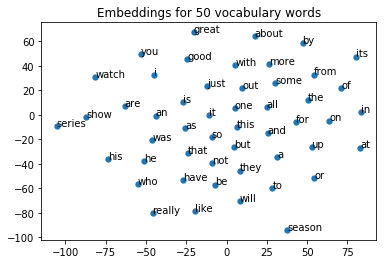

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
weights = []
weight_labels=[]
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights.append(embedding_vector)
        weight_labels.append(word)
        if len(weight_labels)==50:
            break
tsne = TSNE(n_components=2, verbose=0)
transformed_weights = tsne.fit_transform(weights)
fig, ax = plt.subplots()
plt.title('Embeddings for 50 vocabulary words')
ax.scatter(transformed_weights[:,0], transformed_weights[:,1],lw=0, s=40)
for i, txt in enumerate(weight_labels):
    ax.annotate(txt, (transformed_weights[:,0][i], transformed_weights[:,1][i]))


The two dimensions in the above graph do not seem to show any significant trends. We will now try to visualize certain vocabulary words that we would expect to be related:

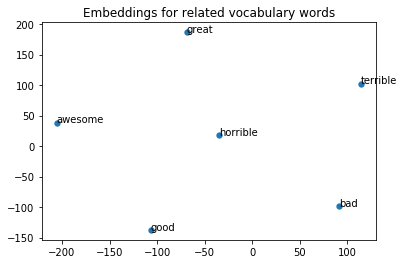

In [52]:
weights = []
weight_labels=[]
related_words = ['bad','terrible','horrible','good','great','awesome']
for word in related_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights.append(embedding_vector)
        weight_labels.append(word)
        if len(weight_labels)==50:
            break
tsne = TSNE(n_components=2, verbose=0)
transformed_weights = tsne.fit_transform(weights)
fig, ax = plt.subplots()
plt.title('Embeddings for related vocabulary words')
ax.scatter(transformed_weights[:,0], transformed_weights[:,1],lw=0, s=40)
for i, txt in enumerate(weight_labels):
    ax.annotate(txt, (transformed_weights[:,0][i], transformed_weights[:,1][i]))


The results above show more clearly the 2D dimensionality reduced embedding space. The positive words, such as "awesome" "good" and "great", show up on the left side of the chart. The negative words, like "awful", show up on the left side. There is a diagonal line that divides the negative words from the positive words.

From these results we can speculate that the X axis primarily and to a lesser extend the Y axis encode sentiment in one way or another. These results are very interesting considering the application of our system; we are primarily interested in a sentiment analysis type of task, so the difference between a positive word and a negative word is very salient to us and our clients.

However, it is likely that the dimensionality reduced space is not a good representation of the 100 dimensional embedding space as a whole. We will look now at the embedding space directly to conduct further analysis.

## Nearest Neighbors

In this section, we analyze the nearest neighbor of various sentiment words in the original 100 dimensional space. We would expect that words of similar sentiment are near to each other and words of opposite sentiment are far from each other.

In [69]:
weights = []
weight_labels=[]
related_words = ['worst','terrible','horrible','best','great','amazing']
for word in related_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights.append(embedding_vector)
        weight_labels.append(word)

from sklearn.neighbors import NearestNeighbors

nbr = NearestNeighbors(n_neighbors=3).fit(weights)

for idx,word in enumerate(related_words):
    _,nearest = nbr.kneighbors(weights[idx:idx+1])
    print('nearest neighbor to','"'+word+'"','is','"'+related_words[nearest[0][1]]+'"',
        'and second nearest is','"'+related_words[nearest[0][2]]+'"')

nearest neighbor to "worst" is "terrible" and second nearest is "horrible"
nearest neighbor to "terrible" is "horrible" and second nearest is "worst"
nearest neighbor to "horrible" is "terrible" and second nearest is "amazing"
nearest neighbor to "best" is "great" and second nearest is "amazing"
nearest neighbor to "great" is "best" and second nearest is "amazing"
nearest neighbor to "amazing" is "great" and second nearest is "horrible"


## Analogies

Finally, in this section we look at the analogies between pairs of words. An analogy occurs in the form of "A is to B as C is to D." For example, "man" is to "king" as "woman" is to ... "queen".

We will use the vector math method for determining analogies. To explain using the above example, we would first find the vector pointing from "man" to "king". Then, we would add this vector to "woman" and expect to find "queen".

We will attempt to find analogies between sentiment words. For example, "good" is to "great" as "bad" is to "terrible."

In [71]:
weights = []
weight_labels=[]
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights.append(embedding_vector)
        weight_labels.append(word)

nbr = NearestNeighbors(n_neighbors=3).fit(weights)

In [94]:
def make_analogy(a,b,c):
    a_vec = embeddings_index.get(a)
    b_vec = embeddings_index.get(b)
    c_vec = embeddings_index.get(c)
    a_to_b_vec = b_vec - a_vec
    d_vec = c_vec + a_to_b_vec
    _,nearest = nbr.kneighbors(np.expand_dims(d_vec,axis=0))
    nearest_words = [weight_labels[i] for i in nearest[0]]
    print(a,'is to',b,'as',c,'is to',nearest_words)
    
make_analogy('good','great','bad')
make_analogy('happy','thrilled','angry')
make_analogy('satisfied','happy','dissatisfied')
make_analogy('delightful','enjoyable','horrible')

good is to great as bad is to ['great', 'bad', 'terrible']
happy is to thrilled as angry is to ['irate', 'angry', 'enraged']
satisfied is to happy as dissatisfied is to ['unhappy', 'happy', 'dissatisfied']
delightful is to enjoyable as horrible is to ['horrible', 'awful', 'horrendous']


The results above show the three closest matches for each analogy. The analogies for sentiment words are pretty much correct. The first analogy, "good is to great as bad is to great," does not work correctly, but even in this case the second guess (bad) and the third guess (terrible) match decently well. 

These analogies demonstrate the way sentiment is encoded in the 100 dimensional space. For example, degree of sentimenent seems to be well represented; good to great represents an increase in degree, similarly as bad to terrible; likewise, happy to thrilled is an increase in degree, as is angry to irate or enraged.

# More Exceptional Credit

For more exceptional credit, we train a character-level novel text generator. We train the generator on text from The Moby Dick.

In [103]:

import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Flatten, TimeDistributed
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy

In [113]:
#Sample function taken from fchollet example on Keras website

def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    choices = range(len(a))
    return np.random.choice(choices,p=a)
    #return np.argmax(np.random.multinomial(1, a, 1))

def ohe_to_words(ohe,padded=True,sample=False):
    if padded:
        letters = [l for l in 'abcdefghijklmnopqrstuvwxyz']
        special = ['PADDING0','\\SPACE','PUNC']
    else:
        letters = [l for l in 'abcdefghijklmnopqrstuvwxyz']
        special = ['PADDING0','\\SPACE','PUNC']
    labels=special+letters
    if sample:
        return np.vectorize(lambda x: labels[x])(ohe)
    else:
        indices = np.argmax(ohe,axis=1)
    return np.vectorize(lambda x: labels[x])(indices)
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def gen_x_y(input_data,seq_length,categorical=False):
    x = rolling_window(input_data.ravel(),seq_length+1)
    y = x[:,-1]
    x = x[:,0:-1]
    if categorical:
        return x,y
    x = to_categorical(x)
    y = to_categorical(y)
    return x,y
def generate_text(rnn, seed, sequence_length, gen_length, temp=0.0):
    predictions = []
    for i in range(gen_length):
        prediction = rnn.predict(seed)[-1]
        if temp == 0:
            predictions.append(prediction)
        else:
            predictions.append(sample(prediction,temp))
        seed = np.concatenate((seed[:,1:],np.expand_dims(np.expand_dims(prediction,axis=0),axis=0)),1)
    print(ohe_to_words(np.array(predictions),sample=(temp!=0)))


In [109]:
def train_rnn(X,y,n_epochs,resume=None):

    print('--------------------')
    print('Training for',n_epochs,'epochs')
    print(X.shape,y.shape)
    if resume is not None:
        resume.fit(X, y, epochs=n_epochs, batch_size=64, verbose=0)
        return resume

    sh = X.shape
    NUM_CLASSES = X.shape[2]

    inputs = Input(shape=(sh[1], sh[2]))
    x = LSTM(128,dropout=0.02, recurrent_dropout=0.02,return_sequences=False)(inputs)
    #x = Dense(NUM_CLASSES,activation='softmax')(x)
    x = Dense(29, activation='softmax')(x)
    #x = TimeDistributed(Dense(NUM_CLASSES, activation='sigmoid'))(x)
    rnn=Model(inputs=inputs,outputs=x)
    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[categorical_accuracy])

    rnn.fit(X, y, epochs=n_epochs, batch_size=64, verbose=0)
    return rnn

def eval_rnn(rnn,X,n_iters,seq_length,gen_length):
    for i in range(n_iters):
        #print('Random',i,':')
        seed = X[randint(0,len(X))]
        print('seed:',ohe_to_words(seed),end=' --> ')
        seed = np.expand_dims(seed,axis=0)
        generate_text(rnn,seed,seq_length,gen_length)

In [97]:
def load_moby(n_chars):
    merged = []
    with open('text_data') as f:
        d = [l.strip().lower() for l in f.readlines()]
        for line in d:
            processed = [c for c in line if c in 'abcdefghijklmnopqrstuvwxyz ']
            processed = [c if c!=' ' else '\\SPACE' for c in processed ]
            merged.extend(processed)
            merged.append('PUNC')
    return np.array(merged[:n_chars])

In [107]:
def words_to_ohe(words,padded=True):
    if padded:
        letters = [l for l in 'abcdefghijklmnopqrstuvwxyz']
        special = ['PADDING0','\\SPACE','PUNC']
    else:
        letters = [l for l in 'abcdefghijklmnopqrstuvwxyz']
        special = ['PADDING','\\SPACE','PUNC']
    labels=special+letters
    words_arr = np.asarray(words)
    return to_categorical(np.vectorize(lambda x: labels.index(x))(words_arr))

In [114]:
from random import randint

moby_data = load_moby(100000)
expanded_moby_data = np.expand_dims(moby_data,axis=1)

key_rnn, moby_rnn = None, None

for n in [5]:
    for gen_length in [10]:
        for epochs in [80]:
            moby_X, moby_y = gen_x_y(expanded_moby_data,n,True)
            moby_X = words_to_ohe(moby_X)
            moby_y = words_to_ohe(moby_y)
            print('Moby with sequence length of',n)
            moby_rnn = train_rnn(moby_X,moby_y,epochs,moby_rnn)
            eval_rnn(moby_rnn,moby_X,10,n,gen_length)
            print('\n')

Moby with sequence length of 5
--------------------
Training for 80 epochs
(99995, 5, 29) (99995, 29)
seed: ['s' 't' 'i' 'm' 'a'] --> ['t' 'e' '\\SPACE' 't' 'h' 'o' 'n' '\\SPACE' 'i' '\\SPACE']
seed: ['\\SPACE' 'a' 'n' 'd' '\\SPACE'] --> ['t' 'o' 'n' 'e' '\\SPACE' 'w' 'r' 'e' 'd' '\\SPACE']
seed: ['o' 'w' 'PUNC' 'c' 'o'] --> ['n' 'f' 'i' 'c' 'e' '\\SPACE' 't' 'o' 'u' 'i']
seed: ['l' 'l' 'e' 'd' '\\SPACE'] --> ['a' 'i' 't' 'd' 'i' 'n' '\\SPACE' 'i' 't' '\\SPACE']
seed: ['\\SPACE' 'f' 'i' 'n' 'd'] --> ['\\SPACE' 'o' 'u' 't' '\\SPACE' 'o' 'o' 'r' '\\SPACE' 's']
seed: ['o' 'r' 'i' 'e' 's'] --> ['\\SPACE' 't' 'h' 'd' 'l' 'o' 'f' '\\SPACE' 'm' 'i']
seed: ['\\SPACE' 'a' '\\SPACE' 'l' 'i'] --> ['t' 't' 'l' 'e' '\\SPACE' 's' 'e' 'n' 'd' 'i']
seed: ['m' 'a' 'n' '\\SPACE' 'l'] --> ['i' 's' 'i' 'n' 'y' '\\SPACE' 't' 'o' 'n' 'e']
seed: ['PUNC' 'a' 'n' 'd' '\\SPACE'] --> ['s' 'o' 'n' 'e' '\\SPACE' 'w' 'i' 'o' 'd' '\\SPACE']
seed: ['PUNC' 'r' 'e' 'd' '\\SPACE'] --> ['w' 'o' 't' 'd' '\\SPACE' 'f' 'o' 

The results above show that training character level generation off a small sample size (100,000 characters) is enough to understand the basic structure of words, but not learn meaningful words. The results appear to have spaced in the proper locations, and the worst appear to be of the currect mength; however, they are not english words.